<a href="https://colab.research.google.com/github/tiwarylab/SPIB-plumed-masterclass-2022/blob/main/Tutorial_1_plumed_SPIB_masterclass_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PLUMED Masterclass 22.7: State Predictive Information Bottleneck (RAVE)**


**Authors** Pratyush Tiwary, Shams Mehdi, Dedi Wang


**Date** May 9, 2022



**Aims**

The aim of this Masterclass is to introduce users to the [ State Predictive Information Bottleneck (SPIB)](https://aip.scitation.org/doi/10.1063/5.0038198) method beloning to the general family of Reweighted Autoencoded Variational Bayes for Enhanced Sampling (RAVE). We will demonstrate how SPIB can be used to analyze and enhance molecular dynamics trajectories. The Masterclass was prepared to be run seamlessly on [Google Colab](https://colab.research.google.com/) but with only minor adjustments you can run it elsewhere.


**Prerequisites**

You should have a working knowledge of Python. Some familiarity with PyTorch is useful but not essential. We install various software recommended for the Plumed Masterclass even though they might not be needed in this tutorial.


**Objectives**

1.   Understand theory behind SPIB
2.   Use SPIB to analyze model 4-state system trajectory
3.   Understand SPIB hyperparameters
4.   Develop understanding to be able to use SPIB to perform biased metadynamics simulations




# **Part 1: SPIB Demo on 4-state potential using PyTorch**

# The basic framework behind SPIB can be summarized as follows.

<img src="https://github.com/tiwarylab/State-Predictive-Information-Bottleneck/blob/main/fig/Fig_alg.png?raw=1">

# We now clone the demo code from [TiwaryLab GitHub](https://github.com/tiwarylab) and do some preliminary setup for visualization

In [2]:
!git clone https://github.com/tiwarylab/State-Predictive-Information-Bottleneck

Cloning into 'State-Predictive-Information-Bottleneck'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 157 (delta 39), reused 33 (delta 33), pack-reused 96 (from 1)
Receiving objects: 100% (157/157), 5.86 MiB | 16.77 MiB/s, done.
Resolving deltas: 100% (86/86), done.


In [3]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [4]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

# We now load and visualize a trajectory (i.e. time-series where at every data point is a high-dimensional vector - for e.g. COLVAR file from PLUMED). The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated beforehand from Langevin dynamics simulation of a four-well analytical potential in two dimensions.

In [5]:
traj_data = np.load("State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_traj_data.npy")

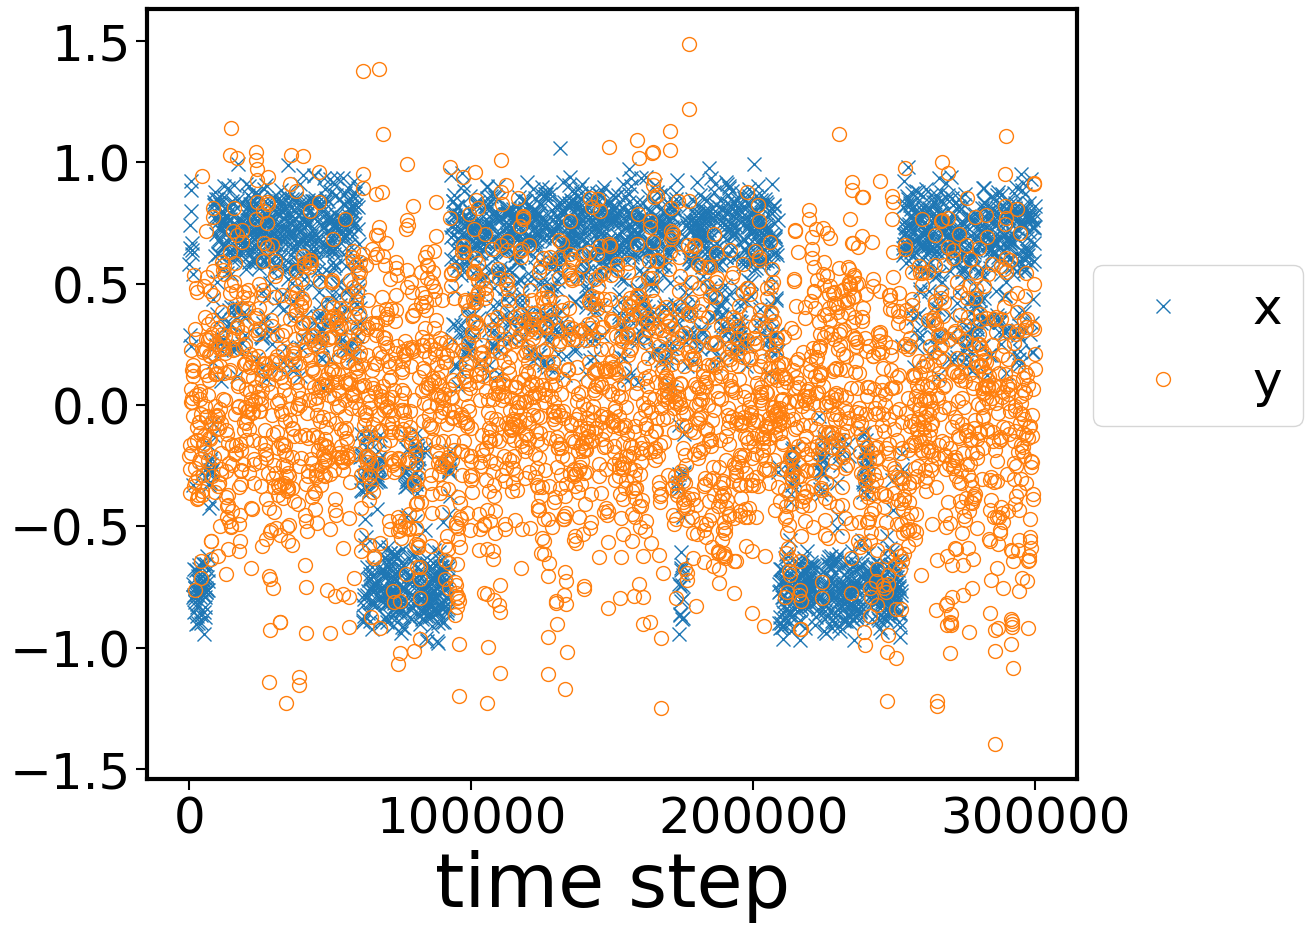

In [6]:
fig, ax = plt.subplots(figsize=(12,10))

t = np.arange(traj_data.shape[0])
ax.plot(t[::100],traj_data[::100,0],'x',label='x')
ax.plot(t[::100],traj_data[::100,1],'o',fillstyle='none',label='y')
ax.set_xlabel('time step')
ax.legend(fontsize=36,bbox_to_anchor=(0.99, 0.7))

# We also define the analytical potential used to generate the trajectory as it will come handy.

In [7]:
# The four-well analytical potential along x
def potential_fn_FW(x):
    A=0.6
    a=80
    B=0.2
    b=80
    C=0.5
    c=40
    return 2*(x**8+A*np.exp(-a*x**2)+B*np.exp(-b*(x-0.5)**2)+C*np.exp(-c*(x+0.5)**2))+(x**2-1)**2

# We visualize the analytical 1-d free energy when projected along x-coordinate, and the 2-d free energy generated from histogramming the trajectory we just loaded.

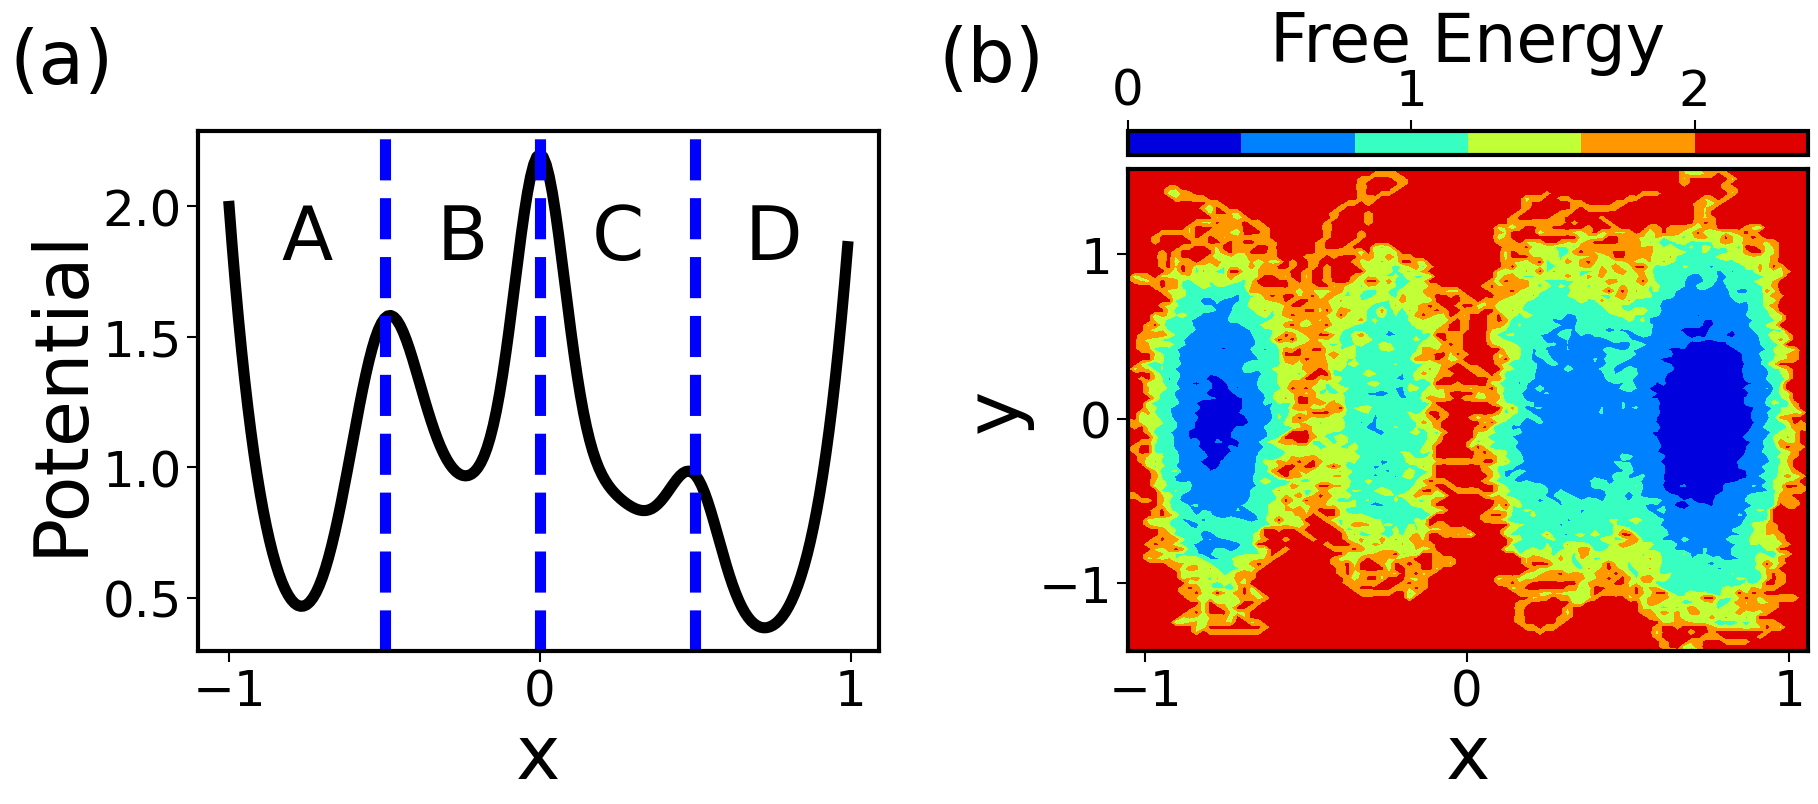

In [8]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(1,2,figsize=(18,8))

beta=3
lw=8

x=np.arange(-1,1,0.01)
v=potential_fn_FW(x)
ax[0].plot(x,v,color='k',lw=lw)
ax[0].axvline(x=0,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=-0.5,color='b',linestyle='--',lw=lw)
ax[0].axvline(x=0.5,color='b',linestyle='--',lw=lw)
ax[0].text(-0.75, 1.8, 'A', horizontalalignment='center',fontsize=54)
ax[0].text(-0.25, 1.8, 'B', horizontalalignment='center', fontsize=54)
ax[0].text(0.25, 1.8, 'C', horizontalalignment='center',fontsize=54)
ax[0].text(0.75, 1.8, 'D', horizontalalignment='center', fontsize=54)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Potential")

ax[0].text(-0.2, 1.2, '(a)', horizontalalignment='center',
             transform=ax[0].transAxes,fontsize=54, va='top')

FW_counts,FW_xbins,FW_ybins,images = plt.hist2d(traj_data[:,0],traj_data[:,1],bins=100)
FW_counts[FW_counts==0]=FW_counts[FW_counts!=0].min()
FW_G=-np.log(FW_counts)/beta
FW_G=FW_G-np.nanmin(FW_G)

h0=ax[1].contourf(FW_G.transpose(),levels=5,extent=[FW_xbins[0],FW_xbins[-1],FW_ybins[0],FW_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,FW_G.max(),1)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label('Free Energy',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax[1].set_xlabel("x")
ax[1].set_ylabel('y')


ax[1].text(-0.2, 1.3, '(b)', horizontalalignment='center',
             transform=ax[1].transAxes,fontsize=54, va='top')

plt.tight_layout(pad=0.4, w_pad=5, h_pad=3.0)

# We generate initial state labels along x. Thus, points with similar x-values are given the same initial state labels. We start with 10 initial states and visualize these on top of the free energy made from the histogram.

In [9]:
index=0

x_max=traj_data[:,index].max()+0.01
x_min=traj_data[:,index].min()-0.01

state_num=10
eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

init_label=np.zeros((traj_data.shape[0],state_num))

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

for j in range(state_num):
    indices=(traj_data[:,index]>x_list[j])&(traj_data[:,index]<=x_list[j+1])
    init_label[indices,j]=1

np.save('State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_init_label10.npy',init_label)

Text(0, 0.5, 'y')

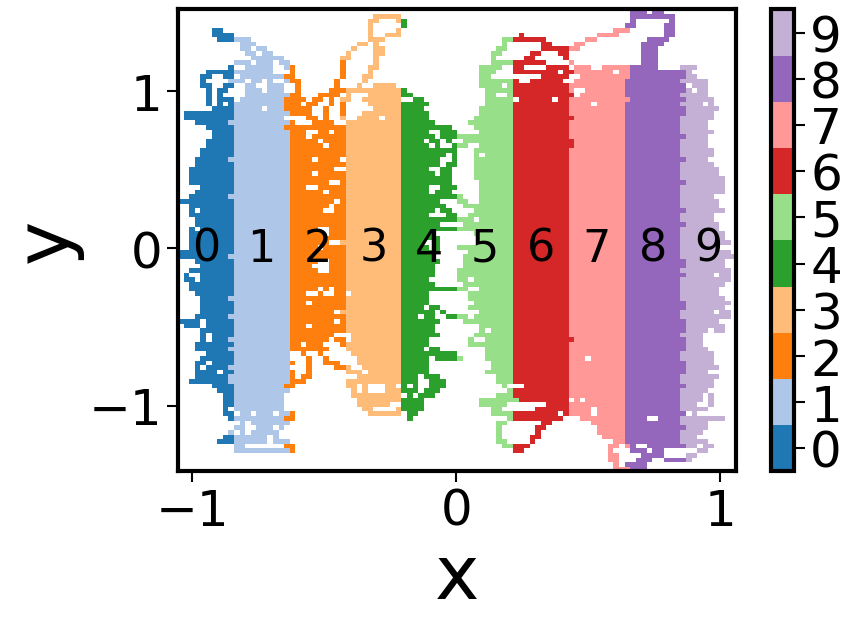

In [10]:
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=init_label

fig0, ax0 = plt.subplots(figsize=(9,6))
hist=ax0.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.shape[1]
state_labels=np.arange(state_num)

x_max=np.max(data[:,0])
x_min=np.min(data[:,0])

eps=1e-3

x_det=(x_max-x_min+2*eps)/state_num

x_list=np.array([(x_min-eps+n*x_det) for n in range(state_num+1)])

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=ax0.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]

init_label_map=np.argmax(hist_state,axis=0).astype(float)
init_label_map[hist[0]==0]=np.nan
plt.close(fig0)

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], init_label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

for i in range(state_num):
    ax.text((x_list[i]+x_list[i+1])/2,0,state_labels[i],horizontalalignment='center',verticalalignment='center',fontsize=32)

plt.xlabel("x")
plt.ylabel("y")



#We are now ready to run SPIB! The command we are going to use for this is going to look like:

```
%run State-Predictive-Information-Bottleneck/test_model.py -dt 50 -d 1 -encoder_type Nonlinear -bs 512 -threshold 0.01 -patience 2 -refinements 8 -lr 0.001 -b 0.01 -seed 0 -label State-Predictive-Information-Bottleneck/examples/system_init_label10.npy -traj State-Predictive-Information-Bottleneck/examples/system_traj_data.npy
```

# The basic syntax above is

```
python test_model.py
      -dt  # Time delay delta t or how far into the future is SPIB trying to predict
      -d	# Dimension of the RC or information bottleneck
      -encoder_type	# Encoder type (Linear or Nonlinear)
      -n1	# Number of nodes in each hidden layer of the encoder
      -n2	# Number of nodes in each hidden layer of the decoder
      -bs # Batch size
      -threshold	# Threshold of the predicted state population change used to measure the convergence of training for each iteration
      -patience	# Number of epochs with the change of the state population smaller than the threshold after which this iteration of training finishes
      -refinements	# Number of refinements
      -lr	# Learning rate of Adam optimizer
      -b	# Hyperparameter beta
      -label	# Path to the initial state labels
      -traj	# Path to the trajectory data
      -w	# Path to the weights of the samples
      -seed	# Random seed
      -UpdateLabel	# Whether to refine the labels during the training process
      -SaveTrajResults	# Whether save trajectory results
```

# We will first run the code once with a default set of parameters, visualize the results, and then come back to understanding the parameters better. We will use a 1-d non-linear encoder RC, and start with 10 initial state labels. We will then visualize:

#(1) final number of states after convergence and where they are located

#(2) converged RC projected in the 2-d {x,y} space




In [11]:
%run State-Predictive-Information-Bottleneck/test_model.py -dt 50 -d 1 -encoder_type Nonlinear -bs 512 -threshold 0.01 -patience 2 -refinements 8 -lr 0.001 -b 0.01 -seed 0 -label State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_init_label10.npy -traj State-Predictive-Information-Bottleneck/examples/Four_Well_beta3_gamma4_traj_data.npy

Iteration 500:	Time 7.861014 s
Loss (train) 1.008286	KL loss (train): 2.285483
Reconstruction loss (train) 0.985431
Loss (test) 1.092503	KL loss (test): 2.192392
Reconstruction loss (test) 1.070580
tensor([0.0000, 0.2321, 0.0000, 0.0536, 0.0000, 0.0000, 0.1282, 0.0000, 0.5861,
        0.0000], device='cuda:0')
State population change=0.263945
Epoch: 1

Iteration 1000:	Time 10.471793 s
Loss (train) 0.992667	KL loss (train): 2.359935
Reconstruction loss (train) 0.969067
Loss (test) 0.947157	KL loss (test): 2.336087
Reconstruction loss (test) 0.923797
tensor([0.0000, 0.2280, 0.0000, 0.0578, 0.0000, 0.0000, 0.1452, 0.0000, 0.5690,
        0.0000], device='cuda:0')
State population change=0.024828
Epoch: 2

Iteration 1500:	Time 13.463394 s
Loss (train) 0.976830	KL loss (train): 2.105023
Reconstruction loss (train) 0.955780
Loss (test) 0.918508	KL loss (test): 1.962190
Reconstruction loss (test) 0.898886
tensor([0.0000, 0.2273, 0.0000, 0.0584, 0.0000, 0.0000, 0.1524, 0.0000, 0.5619,
        

<Figure size 1600x1000 with 0 Axes>

# Here we load the results, specifically the deterministic part of the RC learned by SPIB (the mean of the output gaussian distribution of the encoder), and the final state labels learned by SPIB


In [12]:
prefix='SPIB/Unweighted_d=1_t=50_b=0.0100_learn=0.001000'
repeat='0'
traj_mean_rep=np.load(prefix+"_traj0_mean_representation"+repeat+".npy")
traj_labels=np.load(prefix+"_traj0_labels"+repeat+".npy")

# We plot the learned state labels.

Text(0, 0.5, 'y')

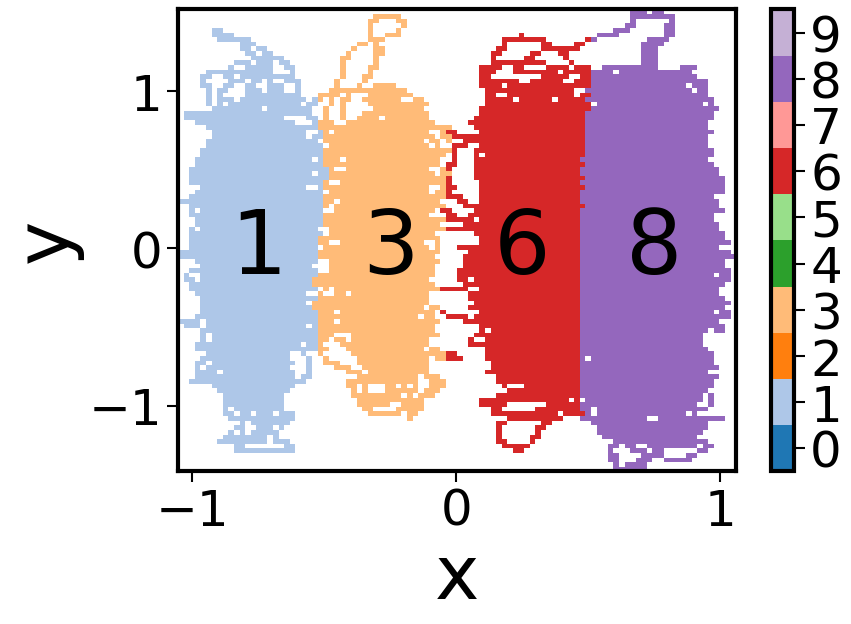

In [13]:
import matplotlib
from matplotlib import colors as c
data=traj_data
labels=traj_labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.shape[1]
state_labels=np.arange(state_num)

hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=labels[:,i])[0]

label_map50=np.argmax(hist_state,axis=0).astype(float)
label_map50[hist[0]==0]=np.nan

plt.close()

fig, ax = plt.subplots(figsize=(9,6))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels))

cMap = c.ListedColormap(plt.cm.tab20.colors[0:10])
im=ax.pcolormesh(hist[1], hist[2], label_map50.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.text(-0.75,0,'1',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.75,0,'8',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(-0.25,0,'3',horizontalalignment='center',verticalalignment='center',fontsize=64)
ax.text(0.25,0,'6',horizontalalignment='center',verticalalignment='center',fontsize=64)

plt.xlabel("x")
plt.ylabel("y")

#Finally we plot the learned RC.

/tmp/ipython-input-454/589822585.py:9: RuntimeWarning: invalid value encountered in divide
  RC=np.divide(hist_RC[0],hist[0])


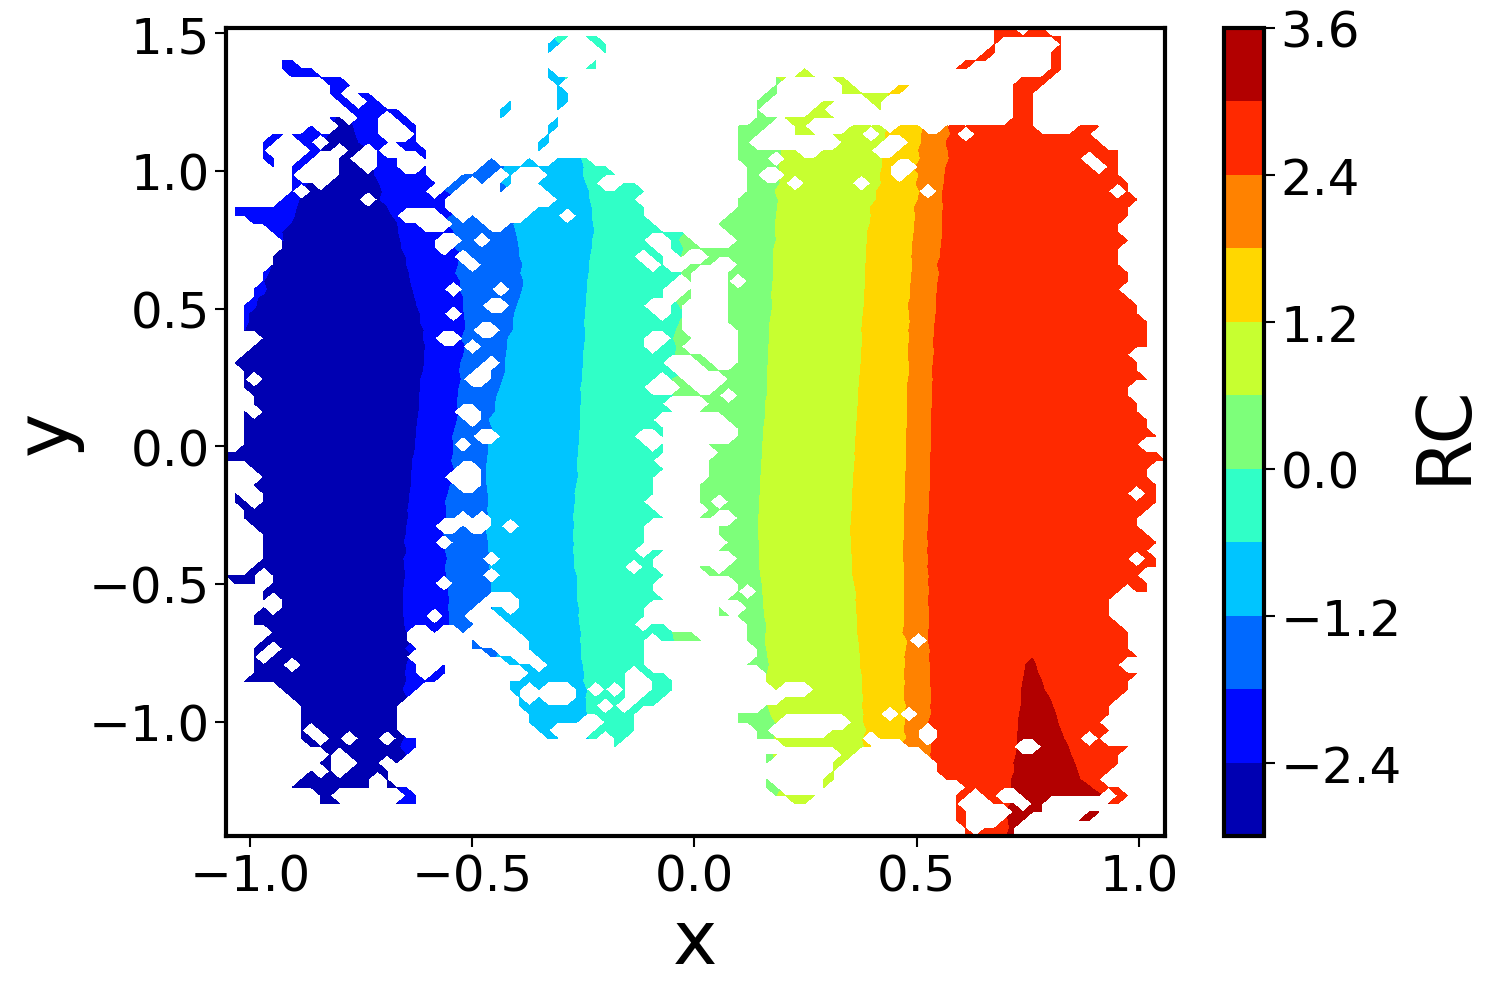

In [14]:
data=traj_data

hist=plt.hist2d(data[:,0],data[:,1],bins=100)
hist_RC=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=traj_mean_rep[:,0])
plt.close()

fig, ax = plt.subplots(figsize=(15,10))

RC=np.divide(hist_RC[0],hist[0])

im=ax.contourf(RC.T, extent=[hist_RC[1][0],hist_RC[1][-1],hist_RC[2][0],hist_RC[2][-1]],levels=10,
                    cmap=plt.cm.jet)
cb1 = fig.colorbar(im,ax=ax)
cb1.set_label('RC')

plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()

#Here are some suggested exercises for you to attempt yourself

# 1. Keeping everything else, change the parameter dt so that the number of converged states is (a) 1, (b) 2, (c) more than 4.

# 2. Similar to exercise 1: now scan across a range of dt values, and note the number of converged states. Make a plot where y-axis is number of converged states and x-axis is the corresponding dt value

# 3. Keep dt value in the range that gives 4 states, and change the scheme for making initial labels. Try two different scheme:
#(a) assign labels along y
#(b) assign labels along x=y